In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#from paths import *
import requests
import pandas as pd
import xarray as xr
import rioxarray as rxr
from os import listdir
from datetime import datetime, timedelta, date
import contextlib
import glob


In [10]:
domain = 'BEAU'
print(domain)

#path to CSO domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# TIME
# choose if want to set 'manual' or 'auto' date 
date_flag = 'manual'
# If you choose 'manual' set your dates below  
st_dt = '2018-10-01'
ed_dt = '2020-09-30'


# PATHS
# path to temporary folder to store tif files from gee
futTIFpath = domain+'_GEE_tmp/'
histTIFpath = '../01_calibrate_cfsv2/'+domain+'_GEE_tmp/'
# # data location
# datapath = '/nfs/attic/dfh/2020_NPRB/data/'
# # SM forcing files 
# SMdatapath = datapath+'SMinputs/'+domain+'/'
# historical met netcdf file
HISTmetfilenc = 'cfsv2_'+st_dt+'_'+ed_dt+'.netcdf'
FUTmetfilenc = 'cfsv2_2098-10-01_2100-09-30.netcdf'

BEAU


In [3]:
# Date setup function
def set_dates(st_dt,ed_dt,date_flag):
    print('setting up dates')
    
    if date_flag == 'auto':
        # ###automatically select date based on today's date 
        hoy = date.today()
        antes = timedelta(days = 2)
        #end date 3 days before today's date
        fecha = hoy - antes
        eddt = fecha.strftime("%Y-%m-%d") 
        #start date
        if fecha.month <10:
            styr = fecha.year - 1
        else:
            styr = fecha.year
        stdt = str(styr)+'-x10-01'
    elif date_flag == 'manual':
        #start date
        stdt = st_dt
        #end date - GEE ends the day before the input end date, so add 1 day
        eddt = (datetime.strptime(ed_dt,'%Y-%m-%d') + timedelta(days = 1)).strftime('%Y-%m-%d')
    return stdt, eddt

In [4]:
# function to check for missing dates
def missing_slice_check(stdt, eddt, TIFpath):
    print('checking for missing dates')
    # create a 6-hourly timeseries with no missing values from the start to end date
    timesin = pd.date_range(start=stdt, end=eddt, freq='6H')[:-1]
    for time in timesin:
        nam = time.strftime('%Y%m%d%H')
        
    # compile list of all tif files downloaded from gee
    gee_times =[]

    for file in listdir(TIFpath):
        if file.endswith("tif"):
            datetmp = datetime.strptime(file[:-4], '%Y%m%d%H')
            gee_times.append(datetmp)
    gee_times = sorted(gee_times)

    # check for to see if all time slices downloaded from GEE
    if len(timesin) != len(gee_times):
        print('gee is missing timeslice(s):\n',timesin[~timesin.isin(gee_times)].values)
        
        # if 4 or more consecutive timeslices are missing - quit the function
        duration = []
        for i in range(len(gee_times)-1):
            time_delta = gee_times[i+1] - gee_times[i]
            duration.append(time_delta.total_seconds()/60/60)
        if max(duration) >= 24:    
            print('at least one full day of met data is missing - quitting function')

        # if there are less than 4 missing consecutive time slices 
        # repeat the met data from the last valid time slice 
        else:
            missing_idx = np.where(~timesin.isin(gee_times))[0]
            missing_dt = timesin[missing_idx]
            for j in range(len(missing_dt)):
                if missing_idx[j] == 0:
                    print('choose earlier start date so missing time slices can be filled in')
                else:
                    pre_dt = TIFpath+timesin[missing_idx[j]-1].strftime('%Y%m%d%H')+'.tif'
                    mis_dt = TIFpath+timesin[missing_idx[j]].strftime('%Y%m%d%H')+'.tif' 
                    get_ipython().system('cp $pre_dt $mis_dt')
                    print('replaced', timesin[missing_idx[j]].strftime('%Y%m%d%H'),' with ', timesin[missing_idx[j]-1].strftime('%Y%m%d%H'))

In [6]:
def met_netcdf(TIFpath):
    print('building .nc')

    ########### met data ###########
    # list of hourly geotif files
    geotiff_list = sorted(glob.glob(TIFpath+'*.tif'))

    # compile list of times associated with the tif files downloaded from gee
    gee_times = [datetime.strptime(file[-14:-4], '%Y%m%d%H') for file in geotiff_list]
    # create a time variable for xarray
    time_var = xr.Variable('time',gee_times)

    # create index to use for reducing dimensionality 
    idx = xr.Variable('idx',np.arange(len(geotiff_list)))

    # Load in and concatenate all individual GeoTIFFs
    geotiffs_da = xr.concat([rxr.open_rasterio(i) for i in geotiff_list],dim=idx)

    ########### output data ###########
    # create output dataset with updated variables and attributes
    dss = xr.Dataset(
    data_vars=dict(
        temp=(["time","y", "x"], geotiffs_da.sel(band=1).values,{'units':'K','long_name':'temperature_height_above_ground'}),
        spech=(["time","y", "x"], geotiffs_da.sel(band=6).values,{'units':'1 (mass fraction)','long_name':'specific_humidity_height_above_ground'}),
        uwind=(["time","y", "x"],geotiffs_da.sel(band=3).values,{'units':'m/s','long_name':'u-component_of_wind_height_above_ground'}),
        vwind=(["time","y", "x"], geotiffs_da.sel(band=4).values,{'units':'m/s','long_name':'u\v-component_of_wind_height_above_ground'}),
        surfp=(["time","y", "x"], geotiffs_da.sel(band=5).values,{'units':'Pa','long_name':'surface_pressure'}),
        prec=(["time","y", "x"], geotiffs_da.sel(band=7).values,{'units':'kg/m^2/s','long_name':'precipitation_rate_surface_6_Hour_average'}),
        elev=(["time","y", "x"], geotiffs_da.sel(band=2).values,{'units':'gpm','long_name':'geopotential_height_surface'}),
    ),
    coords=dict(
        x=geotiffs_da.x,
        y=geotiffs_da.y,
        time=time_var,
    ),
    attrs=geotiffs_da.attrs,)
    # add dataset of origin to attribute list
    dss.attrs.update({'met_dataset':'CFSV2: NCEP Climate Forecast System Version 2, 6-Hourly Products'})
    
    return dss


In [57]:
PRhist = hdss.prec.values
Thist = hdss.temp.values
# open climatena change data 
climnapath = '/nfs/attic/dfh/2020_NPRB/data/climate_na_et/Normal_1991_2020_monthly/'+domain+'/daily_climatena_dif.nc'
climatena = xr.open_dataset(climnapath)

# convert to numpy arrays to speed up computing
tavdif = climatena.tav_dif.values
tmxdif = climatena.tmx_dif.values
tmndif = climatena.tmn_dif.values
prdif = climatena.pr_dif.values

# create a 6-hourly timeseries with no missing values from the start to end date
timesin = pd.date_range(start=stdt, end=eddt, freq='6H')[:-1]

# create day of year index
doyidx = timesin.dayofyear.values

# create hour index
hidx = timesin.hour.values

#load first tif to get dimensions
#ar = xr.open_rasterio(TIFpath+timesin[0].strftime('%Y%m%d%H')+'.tif')

# empty arrays for each met variable
Tfutar = np.empty((len(timesin),len(hdss.y),len(hdss.x)))
PRfutar = np.empty((len(timesin),len(hdss.y),len(hdss.x)))

# extract met data from tifs 
for i in range(len(timesin)):

    # doy index for adjustment factor 
    idx = doyidx[i]-1

    # hour of timeslice
    hr = hidx[i]

    # #load tif file
    # nam = TIFpath+timesin[i].strftime('%Y%m%d%H')+'.tif'
    # ar = xr.open_rasterio(nam)

    # adjust temperatures for future 
    # temp from hist
    t_temp = Thist[i,:,:]
    # temp adjustment 
    if hr == 0:
        tdifslice = tmndif[idx,:,:]
    elif hr == 12:
        tdifslice = tmxdif[idx,:,:]
    elif (hr == 6) |(hr == 18):
        tdifslice = tavdif[idx,:,:]
    # future temp
    tfut = t_temp+tdifslice
    Tfutar [i,:,:] = tfut

    # adjust prec for future 
    # temp from hist
    pr_temp = PRhist[i,:,:]
    # prec adjustment
    pdifslice = prdif[idx,:,:]
    # future prec
    pfut = pr_temp*pdifslice        
    PRfutar [i,:,:] = pfut 

In [58]:
Tf = Tfutar-273.16
hdss['Tf'] = (['time','y', 'x'],Tf)
Pf = PRfutar*24*3600/4
hdss['Pf'] = (['time','y', 'x'],Pf)
hdss

<xarray.Dataset>
Dimensions:      (time: 2924, y: 26, x: 62)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -5.661e+05 -5.439e+05 ... 7.659e+05 7.881e+05
  * y            (y) float64 2.498e+06 2.475e+06 ... 1.965e+06 1.942e+06
  * time         (time) datetime64[ns] 2018-10-01 ... 2020-09-30T18:00:00
Data variables:
    temp         (time, y, x) float32 280.8 280.9 281.0 ... 277.0 275.8 274.2
    spech        (time, y, x) float32 0.005736 0.005524 ... 0.003742 0.003756
    uwind        (time, y, x) float32 -3.42 -3.003 -2.835 ... -4.575 -4.238
    vwind        (time, y, x) float32 7.528 6.972 6.65 ... 0.1 0.0225 -0.2375
    surfp        (time, y, x) float32 1.018e+05 1.018e+05 ... 9.373e+04 9.3e+04
    prec         (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    elev         (time, y, x) float32 -0.288 0.032 0.032 ... 595.7 670.4 709.5
    PR           (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    T            (time, y, x) float32 7.632 7.751 7.889 ... 3.797 2.624 1.037
    Tf           (time, y, x) float64 7.632 7.751 7.889 ... 9.247 8.083 6.517
    Pf           (time, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    met_dataset:   CFSV2: NCEP Climate Forecast System Version 2, 6-Hourly Pr...

In [11]:
# set time parameters
stdt, eddt = set_dates(st_dt,ed_dt,date_flag)

# fill in missing time slices or throw error if missing >4 slices
missing_slice_check(stdt, eddt, histTIFpath)


# add met data to xr dataset
hdss = met_netcdf(histTIFpath)
hdss.to_netcdf(HISTmetfilenc)

# turn prec into mm/6-hours
hdss['PR']=hdss.prec*24*3600/4
#fdss['PR']=fdss.prec*24*3600/4
# temp to C
hdss['T']=hdss.temp-273.16
#fdss['T']=fdss.temp-273.16

setting up dates
checking for missing dates
checking for missing dates
building .nc


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

building .nc


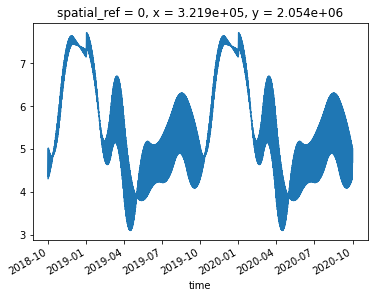

In [67]:
dif = hdss.Tf.isel(x=40,y=20)-hdss.T.isel(x=40,y=20)
dif.plot()

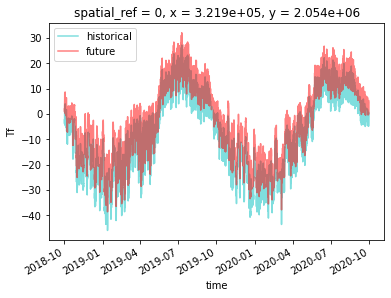

In [62]:


fig, ax = plt.subplots()
hdss.T.isel(x=40,y=20).plot(c='c',label='historical',alpha =0.5)
hdss.Tf.isel(x=40,y=20).plot(c='r',label='future',alpha =0.5)
plt.legend()
fig.savefig(domain+'_metT_pixel_wy2019-2020_wy2099-2100.png',dpi=300)

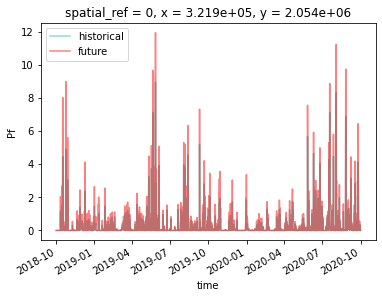

In [63]:
fig, ax = plt.subplots()
hdss.PR.isel(x=40,y=20).plot(c='c',label='historical',alpha =0.5)
hdss.Pf.isel(x=40,y=20).plot(c='r',label='future',alpha =0.5)
plt.legend()
fig.savefig(domain+'_metPREC_pixel_wy2019-2020_wy2099-2100.png',dpi=300)

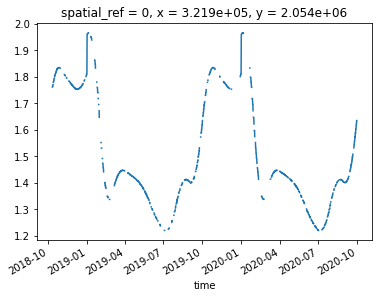

In [71]:
dif = hdss.Pf.isel(x=40,y=20)/hdss.PR.isel(x=40,y=20)
dif.plot()